In [1]:
import pandas as pd, numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, r2_score, accuracy_score, f1_score, precision_score, recall_score, explained_variance_score, mean_absolute_error
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.evaluate import bootstrap
import copy
import warnings
from functools import reduce
warnings.filterwarnings("ignore")

sns.set()

In [4]:
dfs = dict(methylnet=dict(),other=dict())
dfs['methylnet']['pancancer'] = pd.read_csv('methylnet-pancancer_results.csv',index_col=0)
dfs['methylnet']['cell'] = pd.read_csv('methylnet-cell-type-results.csv',index_col=0)
dfs['methylnet']['age'] = pd.read_csv('methylnet-age-results.csv',index_col=0)
dfs['other']['pancancer'] = pd.read_csv('svm-pancancer_sklearn_predictions.csv',index_col=0)
dfs['other']['cell'] = pd.read_csv('EpiDISH-cell-type-results.csv',index_col=0)
dfs['other']['age'] = pd.read_csv('cgage-age-results.csv',index_col=0)
one_hot_encoder = pickle.load(open('one_hot_encoder.p','rb'))
all_age_results = pickle.load(open('age_results.p','rb'))
all_cell_results = pickle.load(open('cell_results.p','rb'))
all_pancancer_results = pickle.load(open('pancancer_results.p','rb'))

In [18]:
df_age=pd.concat((dfs['methylnet']['age'],dfs['other']['age']),axis=1)
df_age.head()

,Age_pred,Age_true,Hannum.Est,EpiTOC.Est,Horvath.Est
GSM2333902_9376538120_R06C01,50.712180,55.0,58.744945,0.062704,54.581645
GSM2333905_9370847096_R06C02,69.474520,74.0,74.166322,0.074922,68.815627
GSM2333914_7766148058_R01C01,56.937664,55.0,70.342944,0.125002,68.190866
GSM2333915_7766148025_R03C02,53.898296,65.0,63.511198,0.067484,57.955661
GSM2333921_7766148058_R03C01,25.300636,29.0,33.173665,0.084883,30.812725


Text(0.5, 1.0, 'MethylNet Age Test Results')

<Figure size 4500x4500 with 0 Axes>

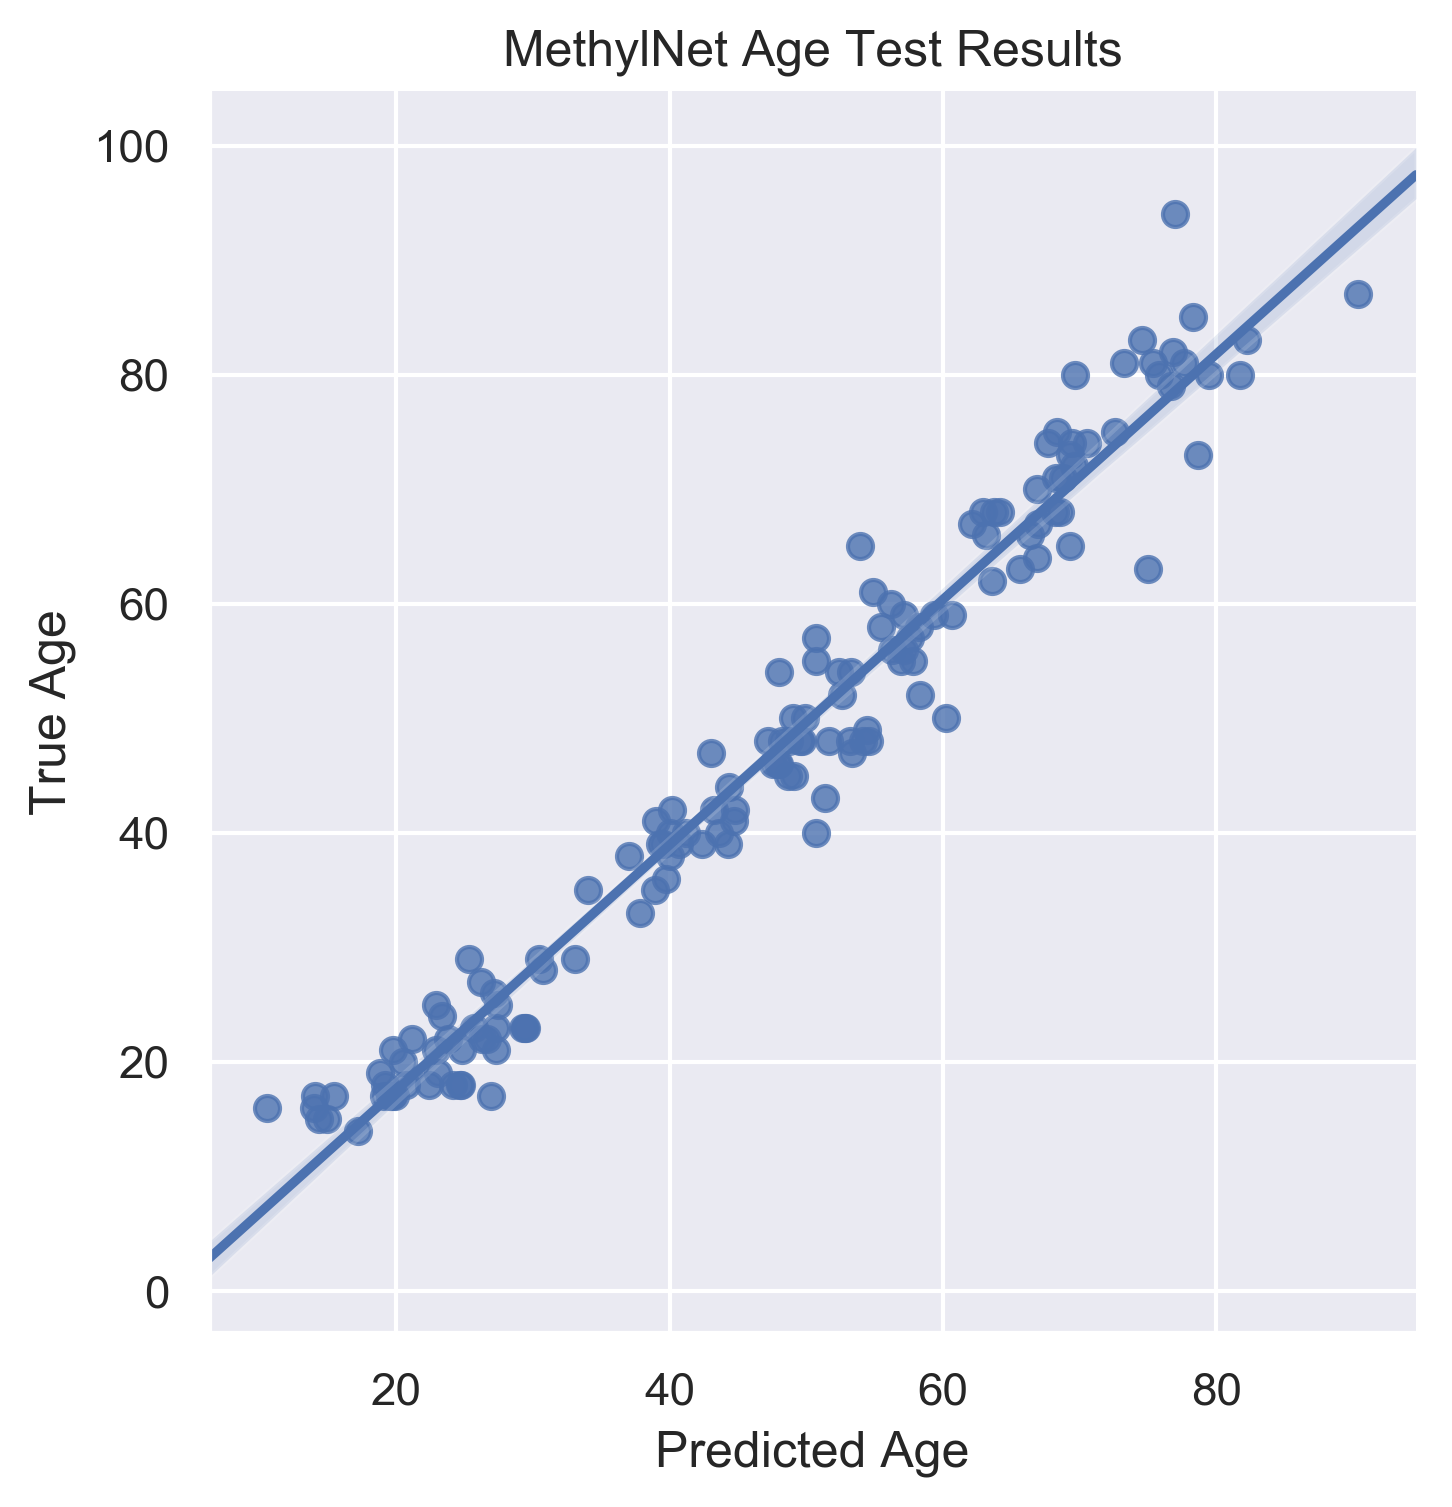

In [16]:
plt.figure(figsize=(15,15))
sns.lmplot('Age_pred','Age_true',data=df_age)
plt.xlabel('Predicted Age')
plt.ylabel('True Age')
plt.title('MethylNet Age Test Results')

Text(0.5, 1.0, 'Top 1K CpGs Overlap with Hannum CpGs')

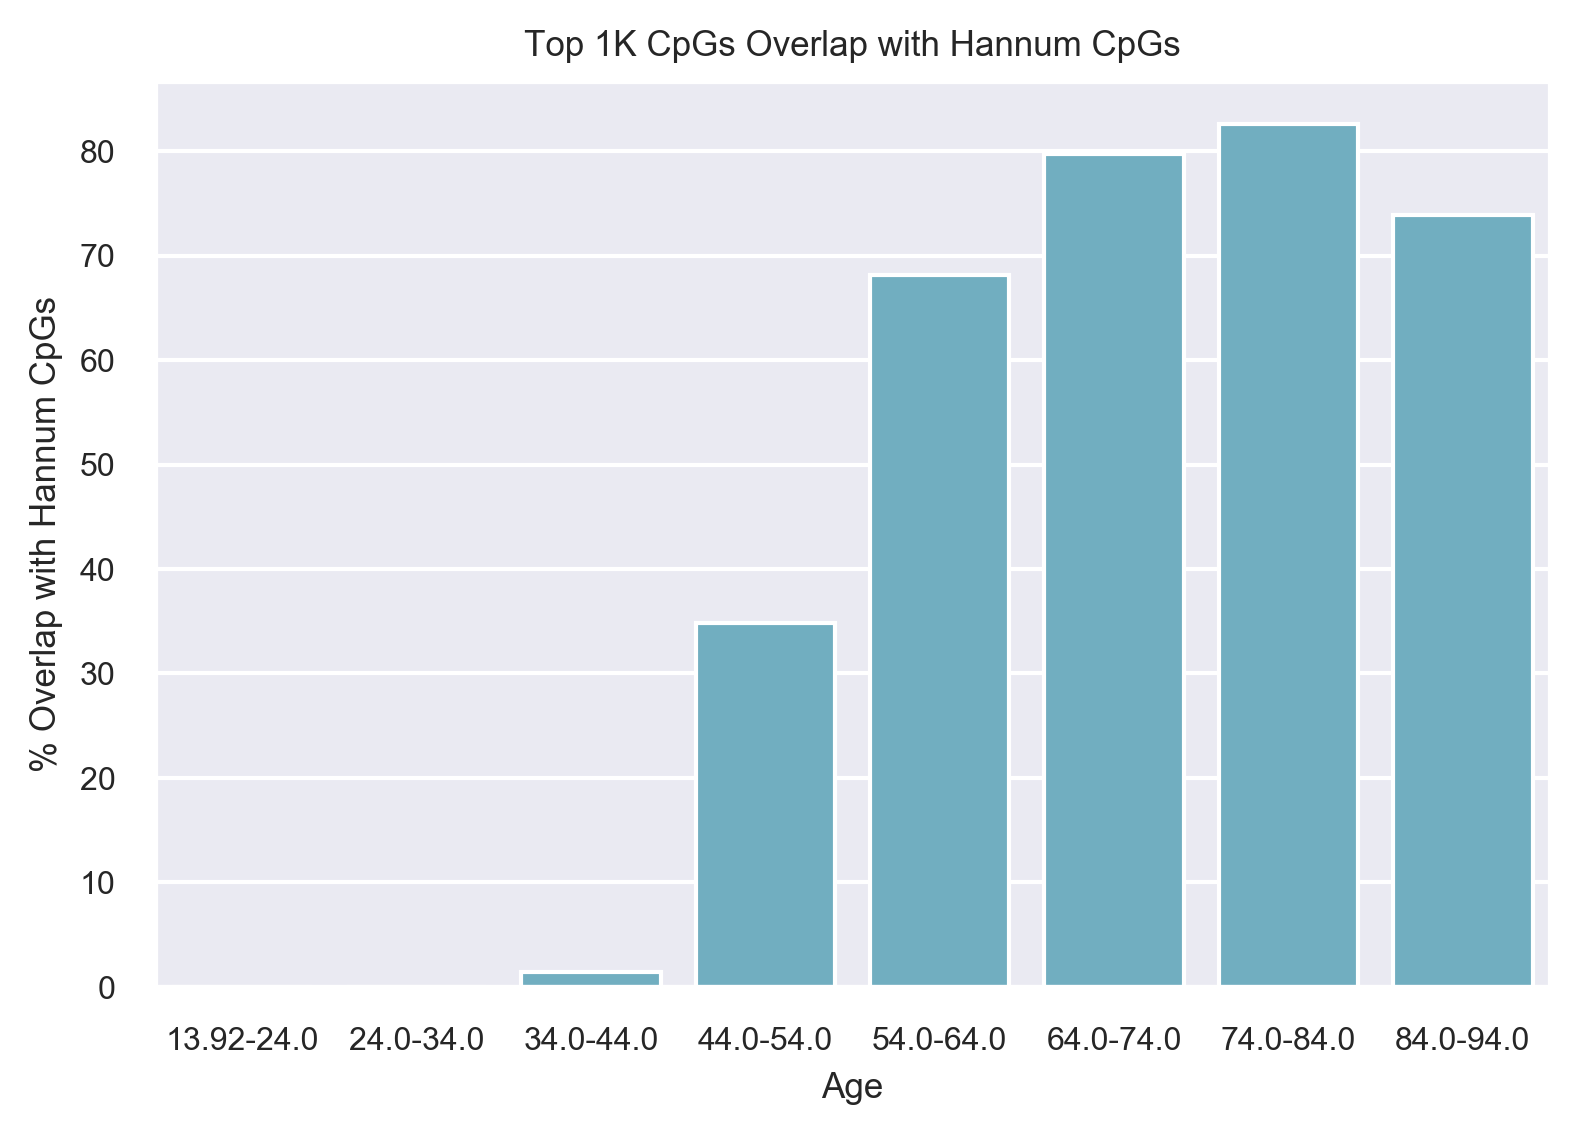

In [26]:
sns.set(font_scale=0.7)
clock_cpg_results = list(map(lambda line: [w.replace('(','').replace(']','').replace(',','-').replace('%','') for w in line.split() if w[-1] in [']','%']],"""(13.92,24.0] top cpgs overlap with 0.0% of hannum cpgs
(24.0,34.0] top cpgs overlap with 0.0% of hannum cpgs
(34.0,44.0] top cpgs overlap with 1.45% of hannum cpgs
(44.0,54.0] top cpgs overlap with 34.78% of hannum cpgs
(54.0,64.0] top cpgs overlap with 68.12% of hannum cpgs
(64.0,74.0] top cpgs overlap with 79.71% of hannum cpgs
(74.0,84.0] top cpgs overlap with 82.61% of hannum cpgs
(84.0,94.0] top cpgs overlap with 73.91% of hannum cpgs""".splitlines()))
plt.figure()
df=pd.DataFrame(clock_cpg_results,columns=['Age','Percent Hannum CpGs'])
df.iloc[:,1]=df.iloc[:,1].astype(float)
sns.barplot('Age','Percent Hannum CpGs',data=df, color=sns.color_palette()[-1])
plt.ylabel('% Overlap with Hannum CpGs')
plt.title('Top 1K CpGs Overlap with Hannum CpGs')


Text(0.5, 1.0, 'MethylNet Age Test Results')

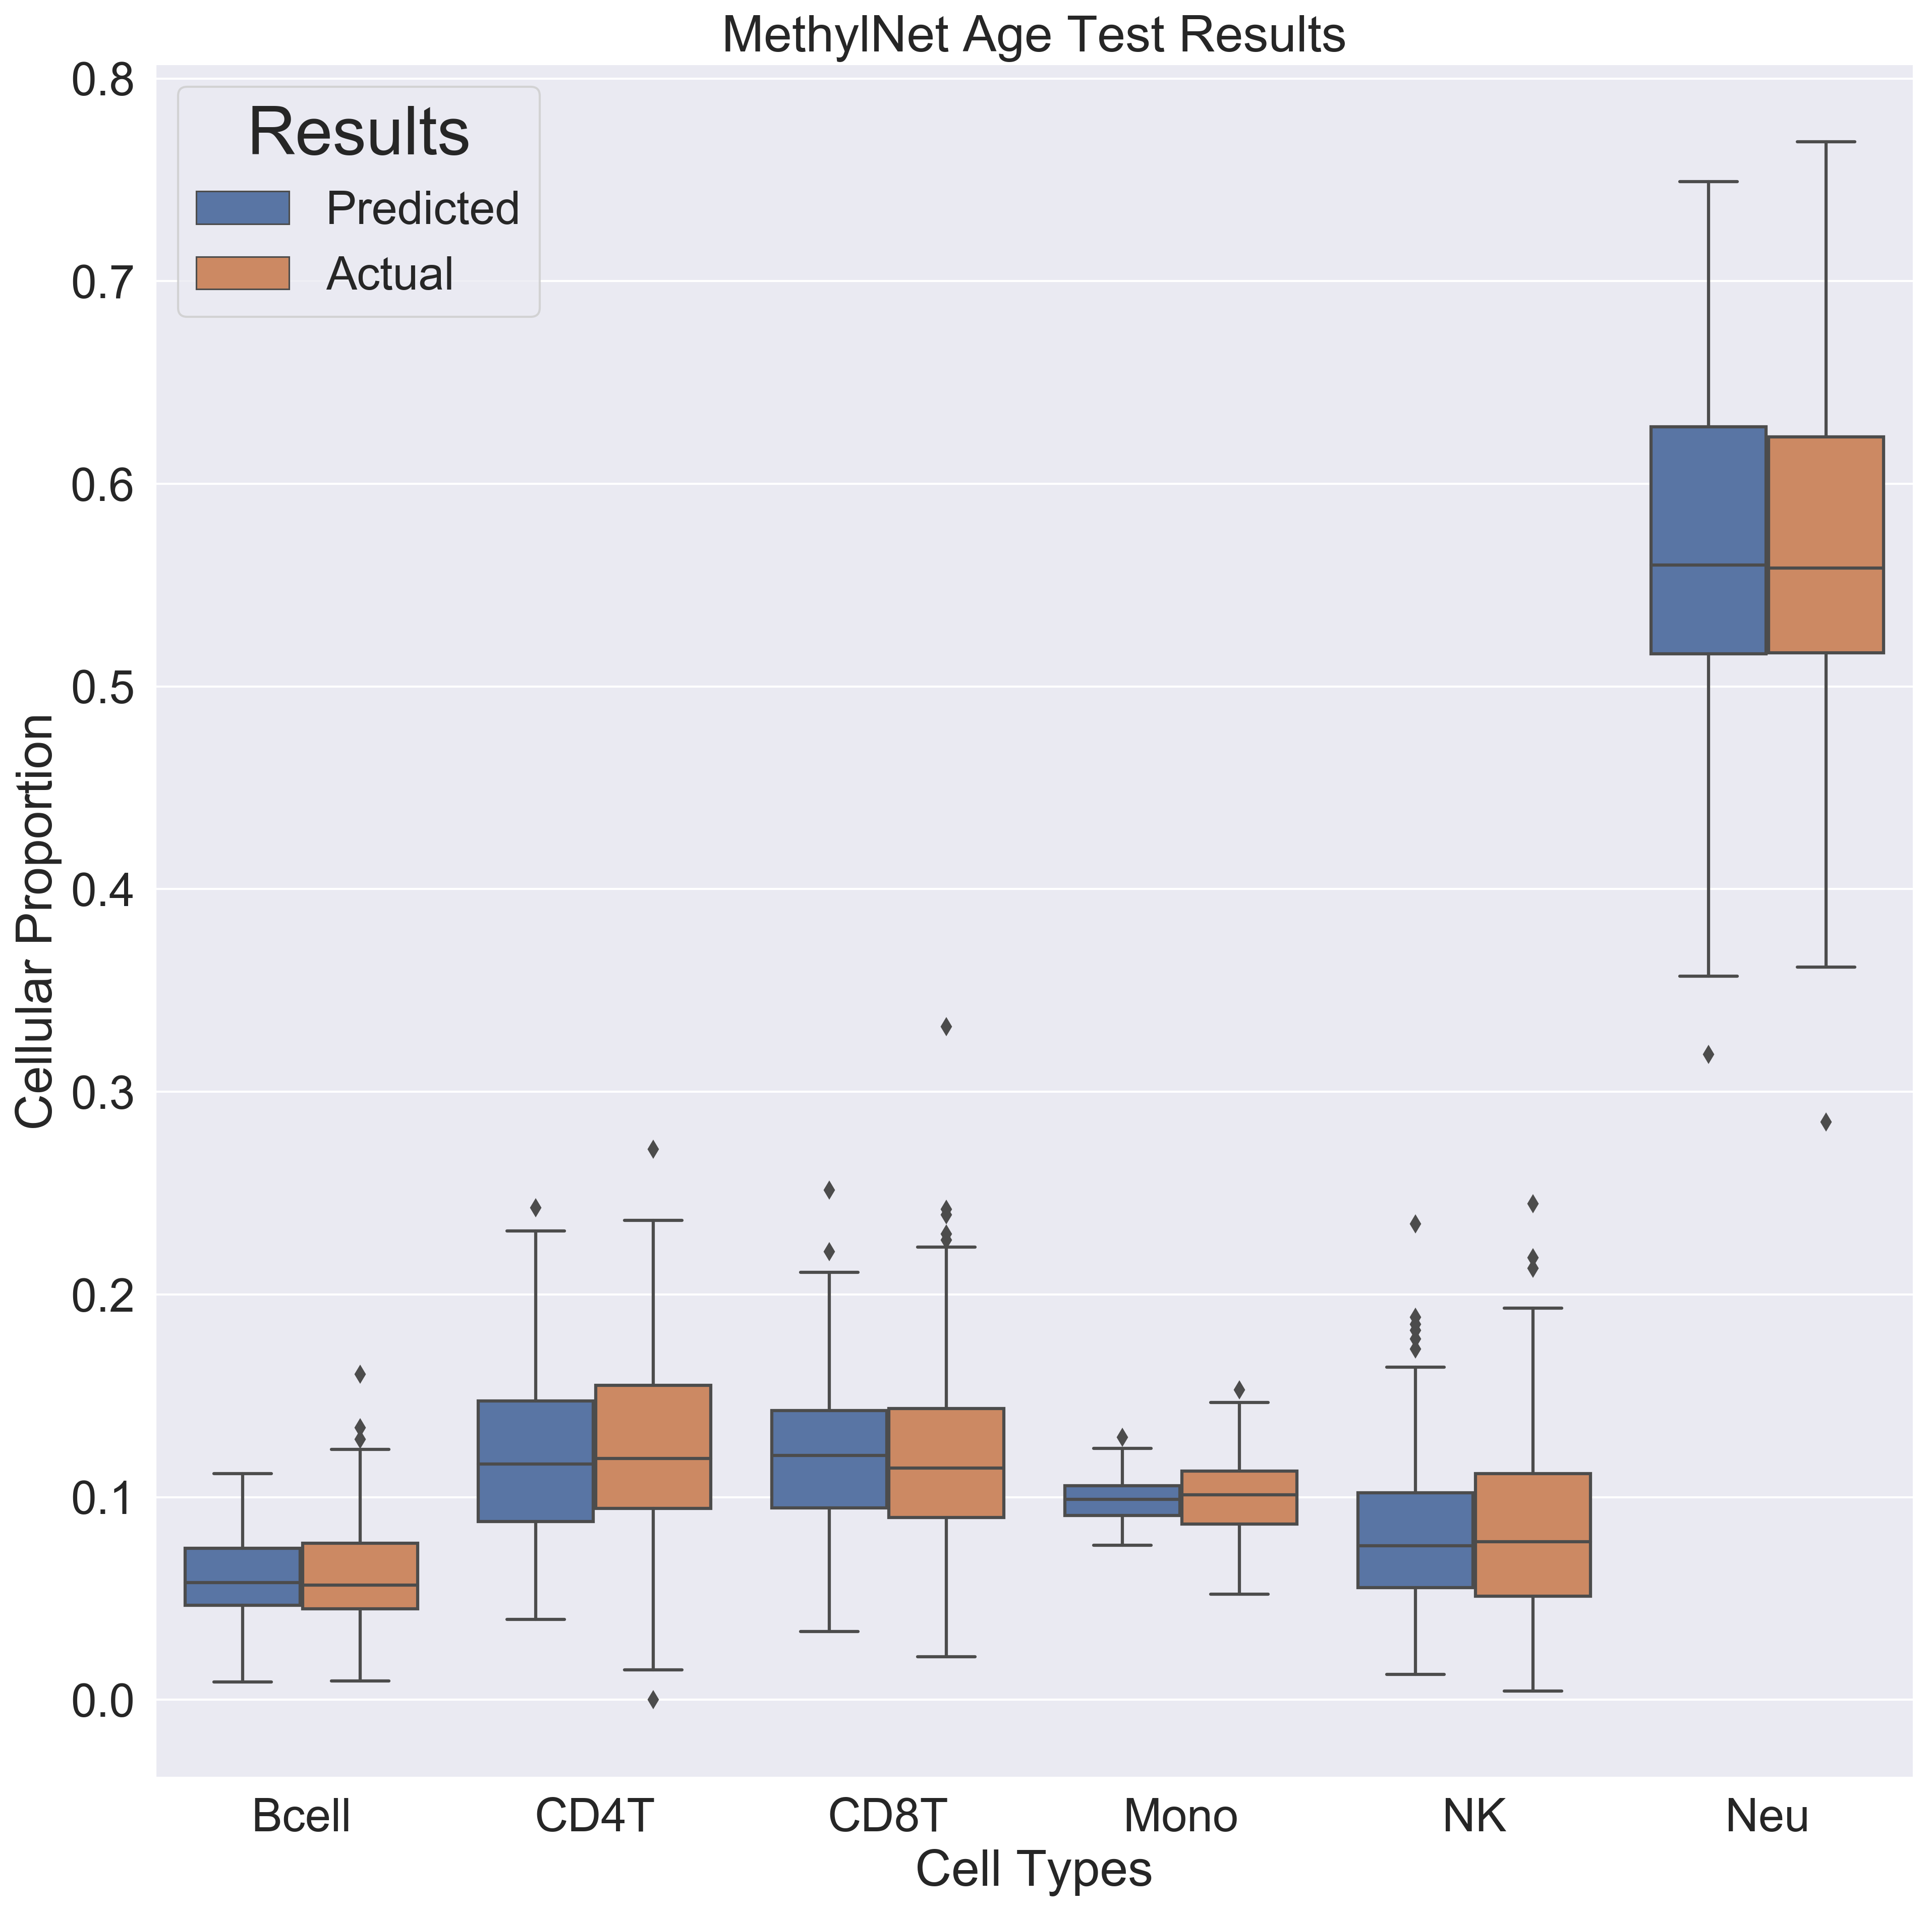

In [53]:
sns.set(font_scale=2.)

cell_df=dfs['methylnet']['cell']
cell_pred,cell_true=cell_df.iloc[:,:6],cell_df.iloc[:,6:]
cell_names = [name.split('_')[0] for name in cell_pred.columns]
cell_pred.columns=cell_names
cell_true.columns=cell_names

cell_pred['Results']='Predicted'
cell_true['Results']='Actual'
cell_df = pd.concat([cell_pred,cell_true])
cell_df2=cell_df.melt(value_vars=cell_names,id_vars='Results')
#print(cell_df)

plt.figure(figsize=(15,15))
ax=sns.boxplot(data=cell_df2,x='variable',y='value',hue='Results')
plt.setp(ax.get_legend().get_texts(), fontsize='22') 
plt.setp(ax.get_legend().get_title(), fontsize='32')
plt.xlabel('Cell Types')
plt.ylabel('Cellular Proportion')
plt.title('MethylNet Age Test Results')

In [88]:

def generate_cell_results():
    for name in cell_names:
        cell_results = dfs['methylnet']['cell'].loc[:,['{}_pred'.format(name),'{}_true'.format(name)]]
        cell_results.columns=['Predicted Proportion','True Proportion']
        cell_results['Cell Type']=name
        yield cell_results
cell_df=pd.concat([result for result in generate_cell_results()],axis=0)

Text(0.5, 0.98, 'MethylNet Predicted vs. True Cell-Type Proportions')

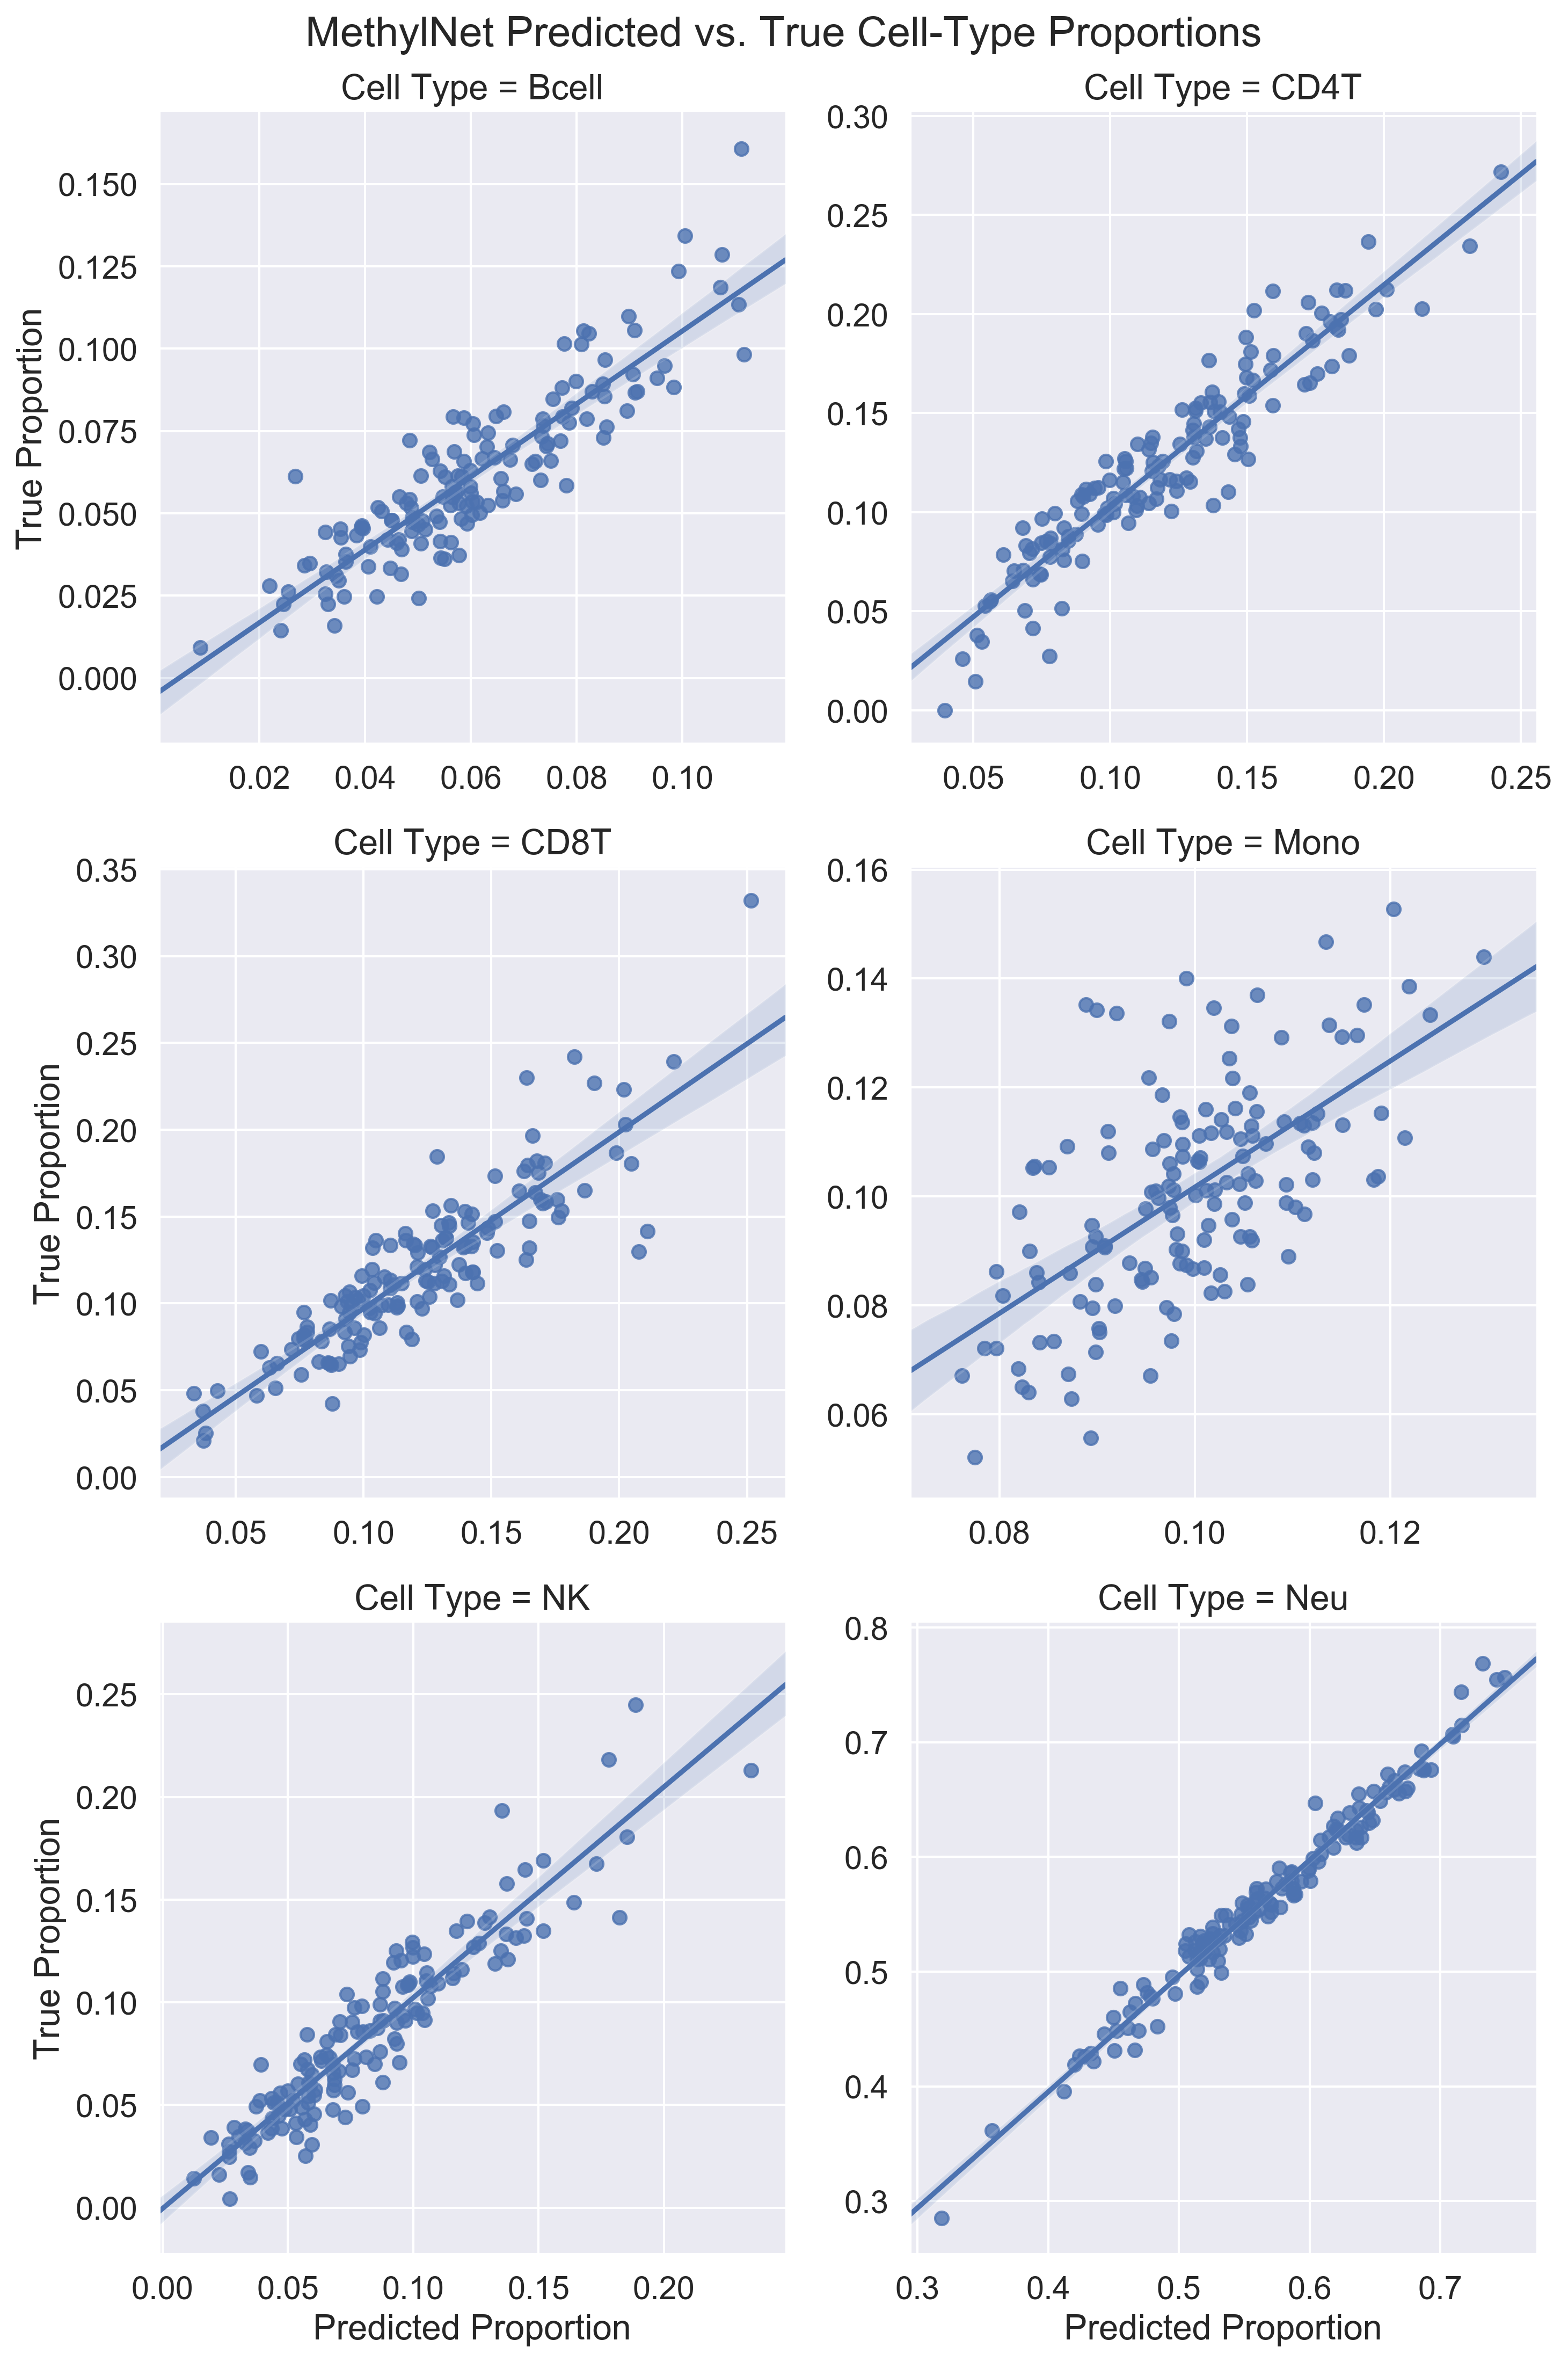

In [89]:
sns.set(font_scale=1.3)

g=sns.lmplot('Predicted Proportion','True Proportion',hue='Cell Type',col='Cell Type',sharex=False,sharey=False,col_wrap=2,palette=[sns.color_palette()[0]]*6,data=cell_df)
plt.subplots_adjust(top=0.94)
g.fig.suptitle('MethylNet Predicted vs. True Cell-Type Proportions')
           

In [7]:
lb=LabelBinarizer()
dfs['methylnet']['pancancer'].loc[:,'y_true'] = one_hot_encoder.inverse_transform(lb.fit_transform(dfs['methylnet']['pancancer'].loc[:,'y_true']))
dfs['methylnet']['pancancer'].loc[:,'y_pred'] = one_hot_encoder.inverse_transform(lb.transform(dfs['methylnet']['pancancer'].loc[:,'y_pred']))



In [8]:
from functools import reduce

In [9]:
clusters=["""PAAD
CHOL
LIHC""".splitlines(),
"""COAD
READ
KIRC
KIRP""".splitlines(),
"""LUAD
LUSC
LAML
ESCA
HNSC
DLBC
STAD""".splitlines(),
"""THCA
THYM
KICH
TGCT
UVM""".splitlines(),
"""MESO
ACC
PCPG
PRAD
BLCA
CESC""".splitlines(),
"""LGG
GBM""".splitlines(),
"""UCEC
UCS
SARC
BRCA
SKCM""".splitlines()]


In [10]:
normalize=True
labels=dfs['methylnet']['pancancer'].loc[:,'y_true'].unique()
labels=list(reduce(lambda x,y: x+y, clusters))
confusion=np.array(confusion_matrix(dfs['methylnet']['pancancer'].loc[:,'y_true'],dfs['methylnet']['pancancer'].loc[:,'y_pred'],labels=labels))
print(confusion)
if normalize:
    confusion=confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
confusion=pd.DataFrame(confusion,index=labels,columns=labels).T




[[ 28   0   0 ...   0   0   0]
 [  0   2   1 ...   0   0   0]
 [  0   2  67 ...   1   0   0]
 ...
 [  0   0   0 ...  44   0   0]
 [  0   0   0 ...   2 149   0]
 [  0   0   0 ...   1   0  82]]


In [11]:
clusters

[['PAAD', 'CHOL', 'LIHC'],
 ['COAD', 'READ', 'KIRC', 'KIRP'],
 ['LUAD', 'LUSC', 'LAML', 'ESCA', 'HNSC', 'DLBC', 'STAD'],
 ['THCA', 'THYM', 'KICH', 'TGCT', 'UVM'],
 ['MESO', 'ACC', 'PCPG', 'PRAD', 'BLCA', 'CESC'],
 ['LGG', 'GBM'],
 ['UCEC', 'UCS', 'SARC', 'BRCA', 'SKCM']]

In [44]:
confusion.to_csv("tables/confusion.csv")

In [45]:
if not normalize:
    confusion.to_csv('pancancer-confusion-matrix.csv')

Text(0.5, 1.0, 'Pancancer Classification Normalized Confusion Matrix')

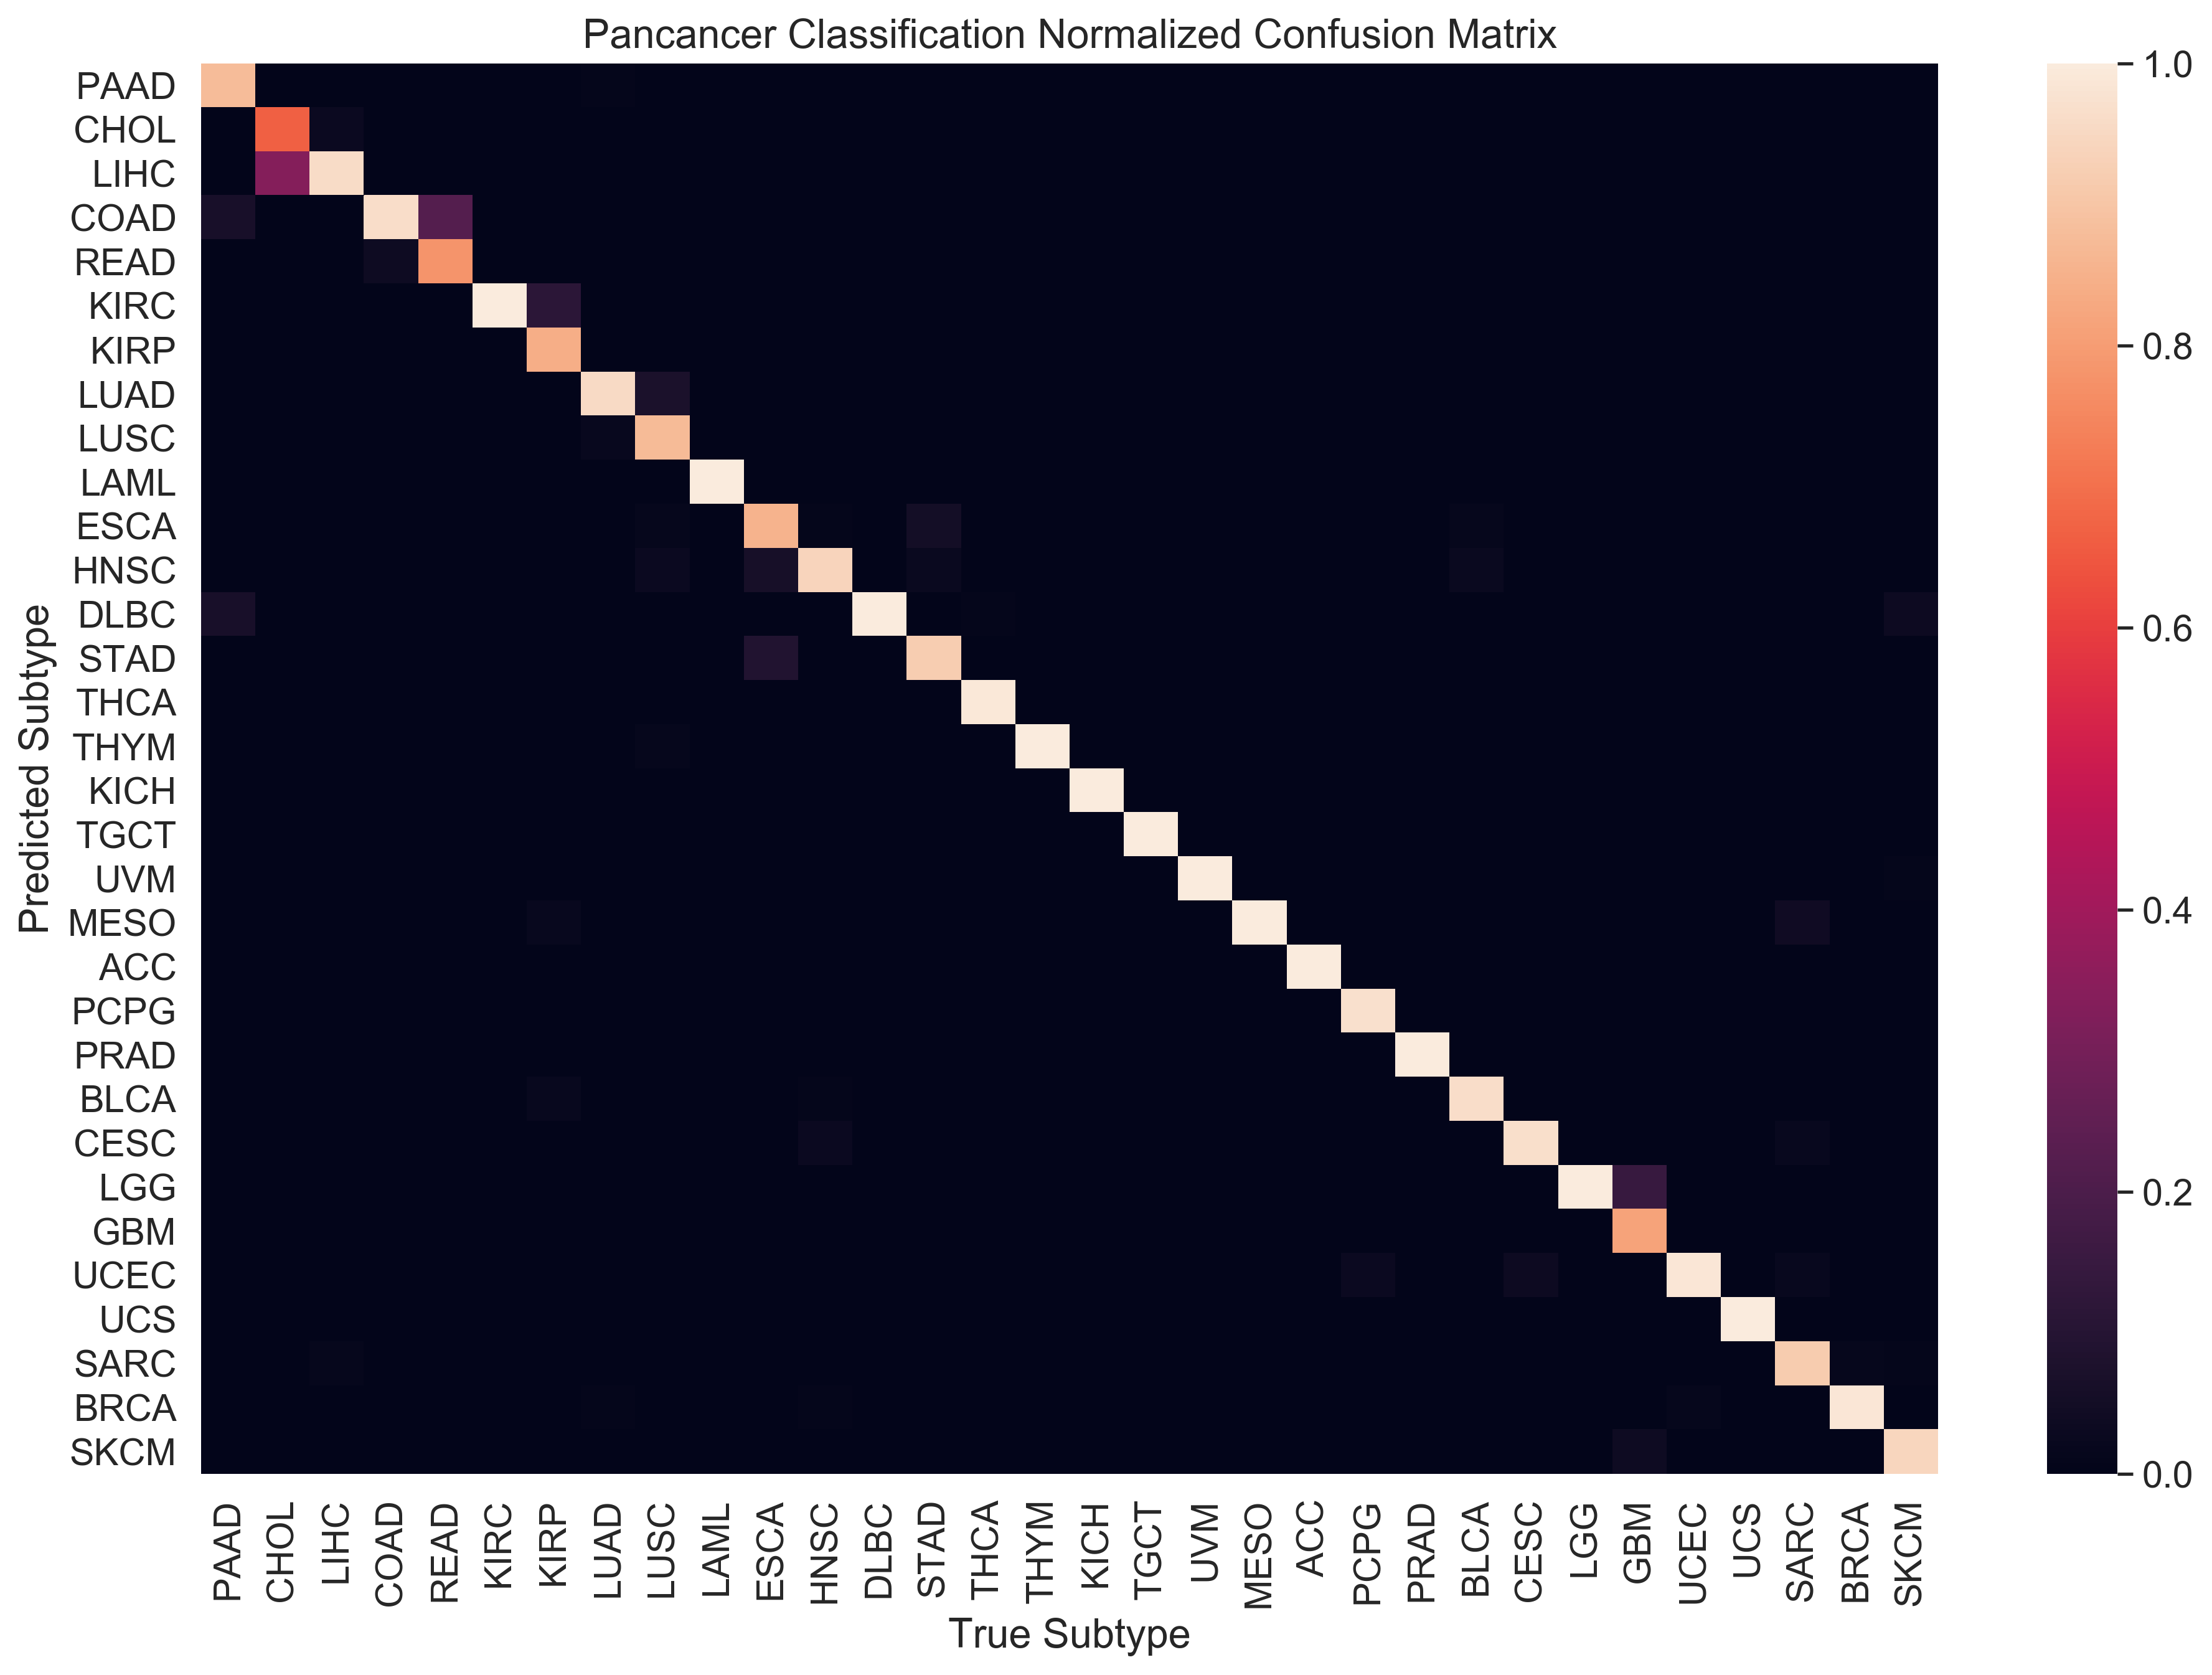

In [96]:
plt.figure(figsize=(15,10))
sns.heatmap(confusion)
plt.xlabel('True Subtype')
plt.ylabel('Predicted Subtype')
plt.title('Pancancer Classification Normalized Confusion Matrix')

In [24]:
embedding_diff=pd.read_csv('class_embedding_differences_p_val.csv',index_col=0)
round(embedding_diff.loc[labels,labels].apply(np.log10),0).fillna('')
#round(embedding_diff.loc[labels,labels],2).to_csv('class_embedding_differences_p-val_reordered.csv')

,PAAD,CHOL,LIHC,COAD,READ,KIRC,KIRP,LUAD,LUSC,LAML,...,PRAD,BLCA,CESC,LGG,GBM,UCEC,UCS,SARC,BRCA,SKCM
PAAD,0,,,,,,,,,,...,,,,,,,,,0.0,
CHOL,,0,,,,,,,,,...,,,,,,,,,0.0,
LIHC,,,0,,,,,-23,,,...,-44,,,0,,0,,,-209.0,-17
COAD,,,,0,,,,,,,...,,,,,,,,,0.0,
READ,,,,,0,,,,,,...,,,,,,,,,-56.0,
KIRC,,,,,,0,,,,,...,-22,,,-24,,,,,0.0,
KIRP,,,,,,,0,,,,...,,,,,,,,,0.0,
LUAD,,,-23,,,,,0,-21,,...,-84,-44,,-108,,-69,,,0.0,-80
LUSC,,,,,,,,-21,0,,...,0,,,0,,0,,,0.0,0
LAML,,,,,,,,,,0,...,,,,,,,,,-71.0,


In [16]:
embedding_diff=pd.read_csv('class_embedding_differences.csv',index_col=0)

round(embedding_diff.loc[labels,labels],2).to_csv('class_embedding_differences_reordered.csv')

In [4]:
average_mechanism='weighted'

def extract_ys(Y):
    return Y[:,0], Y[:,1]

def r2(Y):
    y_true, y_pred=extract_ys(Y)
    return r2_score(y_true, y_pred)

def mae(Y):
    y_true, y_pred=extract_ys(Y)
    return mean_absolute_error(y_true, y_pred)

def explained_variance(Y):
    y_true, y_pred=extract_ys(Y)
    return explained_variance_score(y_true, y_pred)

def accuracy(Y):
    y_true, y_pred=extract_ys(Y)
    return accuracy_score(y_true, y_pred)

def recall(Y):
    y_true, y_pred=extract_ys(Y)
    return recall_score(y_true, y_pred, average=average_mechanism)

def precision(Y):
    y_true, y_pred=extract_ys(Y)
    return precision_score(y_true, y_pred, average=average_mechanism)

def f1(Y):
    y_true, y_pred=extract_ys(Y)
    return f1_score(y_true, y_pred, average=average_mechanism)

In [58]:
scores=[]
for name,dff in dfs['methylnet']['pancancer'].groupby('y_true'):
    Y=dff.loc[:,['y_true','y_pred']].values
    scores.append([accuracy(Y),recall(Y),precision(Y),f1(Y)])

scores=pd.DataFrame(scores,columns=['Accuracy','Recall','Precision','F1'],index=dfs['methylnet']['pancancer']['y_true'].unique()).loc[labels]



In [61]:
round(scores,2).to_csv('tables/pancancer_breakdown.csv')

In [7]:
for k1 in dfs:
    for k2 in dfs[k1]:
        print(k1,k2,list(dfs[k1][k2]))
        
print(dfs['other']['cell']['Est_Method'].unique())
classification_fn = {'accuracy':accuracy, 'recall':recall, 'precision':precision, 'f1':f1}
regression_fn = {'r2':r2, 'mae':mae, 'explained_variance':explained_variance}

methylnet pancancer ['y_pred', 'y_true']
methylnet cell ['Bcell_pred', 'CD4T_pred', 'CD8T_pred', 'Mono_pred', 'NK_pred', 'Neu_pred', 'Bcell_true', 'CD4T_true', 'CD8T_true', 'Mono_true', 'NK_true', 'Neu_true']
methylnet age ['Age_pred', 'Age_true']
other pancancer ['y_pred', 'y_true']
other cell ['CD8T', 'CD4T', 'NK', 'Bcell', 'Mono', 'Neu', 'Est_Method']
other age ['Hannum.Est', 'EpiTOC.Est', 'Horvath.Est']
['Robust Partial Correlations' 'Cibersort' 'Constrained Projection']


In [8]:
def return_bootstrap_results(Y,fn):
    original, std_err, ci_bounds = bootstrap(Y, num_rounds=1000,
                                             func=fn,
                                             ci=0.95,
                                             seed=123)
    return "{}±{}".format(round(original,4),round(std_err,4))

In [23]:
age_res=[]
for k in ['train','val']:
    age_res.append([return_bootstrap_results(pd.DataFrame(np.hstack(all_age_results[k].values()), columns=['y_pred','y_true']).values[:,::-1], regression_fn[fn]) for fn in regression_fn])
    
age_res=pd.DataFrame(age_res,index=['train','val'])
age_res.to_csv('age_train_val_results.csv')
    

In [31]:
cell_res=[]
for i in range(6):
    for k in ['train','val']:
        cell_res.append([return_bootstrap_results(np.vstack((all_cell_results[k]['y_true'][:,i],all_cell_results[k]['y_pred'][:,i])).T, regression_fn[fn]) for fn in regression_fn])
    
cell_res=pd.DataFrame(cell_res)
cell_res.to_csv('cell_train_val_results.csv')



In [16]:
pancancer_res=[]
for k in ['train','val']:
    pancancer_res.append([return_bootstrap_results(np.vstack((np.argmax(all_pancancer_results[k]['y_true'],axis=1),np.argmax(all_pancancer_results[k]['y_pred'],axis=1))).T, classification_fn[fn]) for fn in classification_fn])
    
pancancer_res=pd.DataFrame(pancancer_res)
pancancer_res.to_csv('pancancer_train_val_results.csv')


In [19]:
all_pancancer_results['val']['y_true'].shape

(840, 32)

In [10]:
cell_types = list(dfs['other']['cell'])[:-1]
results = {'Pancancer':{'MethylNet':[],'UMAP+SVM':[]},
          'Cell-Type Deconvolution':{'MethylNet':{k:[] for k in cell_types},'EpiDISH+RPC':{k:[] for k in cell_types},'EpiDISH+Cibersort':{k:[] for k in cell_types},'EpiDISH+CP':{k:[] for k in cell_types}},
          'Age Prediction':{'MethylNet':[],'Hannum Clock':[],'Horvath Clock':[]}}



In [11]:
le=LabelEncoder()
dfs['methylnet']['pancancer'].loc[:,'y_true'] = le.fit_transform(dfs['methylnet']['pancancer'].loc[:,'y_true'])
dfs['methylnet']['pancancer'].loc[:,'y_pred'] = le.transform(dfs['methylnet']['pancancer'].loc[:,'y_pred'])


In [12]:
results['Pancancer']['MethylNet']={fn:return_bootstrap_results(dfs['methylnet']['pancancer'].iloc[:,::-1].values,classification_fn[fn]) for fn in classification_fn.keys()}

In [13]:
le=LabelEncoder()
dfs['other']['pancancer'].loc[:,'y_true'] = le.fit_transform(dfs['other']['pancancer'].loc[:,'y_true'])
dfs['other']['pancancer'].loc[:,'y_pred'] = le.transform(dfs['other']['pancancer'].loc[:,'y_pred'])

In [14]:
results['Pancancer']['UMAP+SVM']={fn:return_bootstrap_results(dfs['other']['pancancer'].iloc[:,::-1].values,classification_fn[fn]) for fn in classification_fn.keys()}



In [15]:
for cell in cell_types:
    results['Cell-Type Deconvolution']['MethylNet'][cell]={fn:return_bootstrap_results(dfs['methylnet']['cell'][[col for col in list(dfs['methylnet']['cell']) if col.startswith(cell)]].iloc[:,::-1].values,regression_fn[fn]) for fn in regression_fn.keys()}
 


In [16]:
analysis_dict = {'Robust Partial Correlations':'RPC', 'Cibersort':'Cibersort', 'Constrained Projection':'CP'}
for name,dff in dfs['other']['cell'].groupby('Est_Method'):
    for cell in cell_types:
        Y=pd.concat([pd.DataFrame(dfs['methylnet']['cell']['{}_true'.format(cell)]),pd.DataFrame(dff[cell])],axis=1).values
        results['Cell-Type Deconvolution']['EpiDISH+{}'.format(analysis_dict[name])][cell]={fn:return_bootstrap_results(Y,regression_fn[fn]) for fn in regression_fn.keys()}

In [17]:
results['Age Prediction']['MethylNet']={fn:return_bootstrap_results(dfs['methylnet']['age'].iloc[:,::-1].values,regression_fn[fn]) for fn in regression_fn.keys()}
for clock in ['Hannum','Horvath']:
    results['Age Prediction']['{} Clock'.format(clock)]={fn:return_bootstrap_results(pd.concat([pd.DataFrame(dfs['methylnet']['age']['Age_true']),pd.DataFrame(dfs['other']['age']['{}.Est'.format(clock)])],axis=1).values,regression_fn[fn]) for fn in regression_fn.keys()}
    


In [176]:
results

{'Pancancer': {'MethylNet': {'accuracy': '0.9553±0.0052',
   'recall': '0.9553±0.0052',
   'precision': '0.9579±0.0048',
   'f1': '0.9555±0.0052'},
  'UMAP+SVM': {'accuracy': '0.8389±0.0091',
   'recall': '0.8389±0.0091',
   'precision': '0.8136±0.0103',
   'f1': '0.8228±0.0098'}},
 'Cell-Type Deconvolution': {'MethylNet': {'CD8T': {'r2': '0.7776±0.0402',
    'mae': '0.0161±0.0012',
    'explained_variance': '0.7807±0.0378'},
   'CD4T': {'r2': '0.8636±0.0177',
    'mae': '0.0141±0.0009',
    'explained_variance': '0.8757±0.0164'},
   'NK': {'r2': '0.8676±0.0174',
    'mae': '0.0122±0.0009',
    'explained_variance': '0.8692±0.0169'},
   'Bcell': {'r2': '0.787±0.026',
    'mae': '0.009±0.0006',
    'explained_variance': '0.789±0.0253'},
   'Mono': {'r2': '0.3729±0.0669',
    'mae': '0.0124±0.0008',
    'explained_variance': '0.3793±0.0622'},
   'Neu': {'r2': '0.9722±0.0043',
    'mae': '0.0107±0.0007',
    'explained_variance': '0.9736±0.0042'}},
  'EpiDISH+RPC': {'CD8T': {'r2': '0.7174

In [18]:
df_pancancer=pd.concat([pd.DataFrame(results['Pancancer'][k],index=[k]) for k in results['Pancancer']])# results['Pancancer']['MethylNet'] = 
df_pancancer.columns = pd.MultiIndex.from_product([['Pancancer'],df_pancancer.columns])
df_pancancer


Pancancer                                             
                accuracy         recall      precision             f1
MethylNet  0.9553±0.0052  0.9553±0.0052  0.9579±0.0048  0.9555±0.0052
UMAP+SVM   0.8389±0.0091  0.8389±0.0091  0.8136±0.0103  0.8228±0.0098

In [19]:
df_age=pd.concat([pd.DataFrame(results['Age Prediction'][k],index=[k]) for k in results['Age Prediction']])# results['Pancancer']['MethylNet'] = 
df_age.columns = pd.MultiIndex.from_product([['Age Prediction'],df_age.columns])
df_age

Age Prediction                                  
                          r2            mae explained_variance
MethylNet       0.956±0.0064   3.439±0.2381      0.9567±0.0063
Hannum Clock   0.8995±0.0128  5.6241±0.2993       0.953±0.0065
Horvath Clock  0.9427±0.0087  3.9356±0.2686      0.9494±0.0078

In [20]:
results_cells = {}

for i,cell in enumerate(cell_types):
    results_cells[cell]=pd.concat([pd.DataFrame(results['Cell-Type Deconvolution'][k][cell],index=[k]) for k in results['Cell-Type Deconvolution']])
    if not i:
        results_cells[cell].columns = pd.MultiIndex.from_product([['Cell-Type Deconvolution'],[cell],results_cells[cell].columns])
    else:
        results_cells[cell].columns = pd.MultiIndex.from_product([[cell],results_cells[cell].columns])




In [35]:
df_pancancer.to_csv("tables/pancancer.csv")
for cell in results_cells:
    results_cells[cell].to_csv("tables/cells_{}.csv".format(cell))

df_age.to_csv("tables/age.csv")

In [239]:
for cell in results_cells:
    print(results_cells[cell].to_latex().replace('±','$\\pm$'))
print(df_age.to_latex().replace('±','$\\pm$'))
print(df_pancancer.to_latex().replace('±','$\\pm$'))

\begin{tabular}{llll}
\toprule
{} & \multicolumn{3}{l}{Cell-Type Deconvolution} \\
{} & \multicolumn{3}{l}{CD8T} \\
{} &                      r2 &            mae & explained\_variance \\
\midrule
MethylNet         &           0.7776\pm 0.0402 &  0.0161\pm 0.0012 &      0.7807\pm 0.0378 \\
EpiDISH+RPC       &           0.7174\pm 0.0612 &  0.0191\pm 0.0013 &      0.7585\pm 0.0521 \\
EpiDISH+Cibersort &            0.6305\pm 0.077 &  0.0226\pm 0.0014 &      0.7472\pm 0.0546 \\
EpiDISH+CP        &            0.7137\pm 0.067 &  0.0186\pm 0.0014 &      0.7241\pm 0.0635 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} & \multicolumn{3}{l}{CD4T} \\
{} &              r2 &            mae & explained\_variance \\
\midrule
MethylNet         &   0.8636\pm 0.0177 &  0.0141\pm 0.0009 &      0.8757\pm 0.0164 \\
EpiDISH+RPC       &    0.337\pm 0.0909 &  0.0361\pm 0.0014 &      0.8901\pm 0.0184 \\
EpiDISH+Cibersort &   0.5995\pm 0.0579 &   0.026\pm 0.0014 &      0.8618\pm 0.0203 \\
EpiDISH

In [ ]:
#print(results_cells.to_latex().replace('±','\\pm'))
dfs['methylnet']['pancancer'].shape
dfs['methylnet']['cell'].shape
dfs
import pylatex
pylatex.Tabular(results_cells.to_latex().replace('±','\\pm'))
from tabulate import tabulate
print(tabulate(results_cells))
(
    results_cells
    .pipe(PrettyPandas)
    .style
    .background_gradient()
)#PrettyPandas(results_cells)
from prettypandas import PrettyPandas
results_cells
#results_cells = pd.concat([results_cells[cell] for cell in results_cells],axis=0) # 1
#results_cells.columns = pd.MultiIndex.from_product([['Cell-Type Deconvolution'],results_cells.columns])